In [1]:
import openpharmacophore.pharmacophore.pl_interactions as pli
import mdtraj as mdt
import nglview as nv
import numpy as np
from matplotlib.colors import to_rgb
from rdkit import Chem
from pprint import pprint
from collections import defaultdict

In [2]:
pli.BS_DIST = 0.55

In [3]:
# Load all necessary data
traj = mdt.load("./er_alpha_A_chain.pdb")
protein = Chem.MolFromPDBFile("./er_alpha_A_chain.pdb")
ligand = Chem.MolFromSmiles("C[C@]12CC[C@@H]3c4ccc(cc4CC[C@H]3[C@@H]1CC[C@@H]2O)O")

print(f"Trajectory has {traj.n_atoms} atoms")
print(f"Protein has {protein.GetNumAtoms()} atoms")
print(f"Ligand has {ligand.GetNumAtoms()} atoms")

Trajectory has 2010 atoms
Protein has 2010 atoms
Ligand has 20 atoms


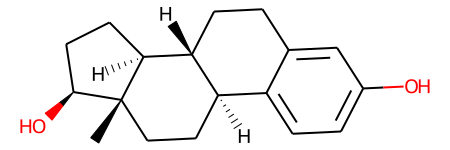

In [4]:
ligand

In [5]:
ligands_ids = pli.find_ligands_in_traj(traj)
lig_id = ligands_ids[0]
print(ligands_ids)

['EST:B']


In [6]:
# Get all necessary ligand data
ligand_indices = pli.get_ligand_atom_indices(traj, lig_id)
lig_centroid = pli.ligand_centroid(traj, lig_id)
lig_extent = pli.ligand_maximum_extent(traj, lig_id)

print(f"Ligand indices len {len(ligand_indices)}")
print(f"Ligand centroid: {lig_centroid}")
print(f"Ligand maximum extent: {lig_extent}")

Ligand indices len 20
Ligand centroid: [10.503935   1.4664251  2.3460498]
Ligand maximum extent: 0.598493754863739


In [7]:
ligand_features_rd = pli.chemical_features(ligand)
# Map rdkit ligand indices to mdtraj's
rd_indices = list(range(0, ligand.GetNumAtoms()))
indices_map = dict(zip(rd_indices, ligand_indices))

ligand_features = defaultdict(list)
for feat_name, indices_list in ligand_features_rd.items():
    feat_indices = []
    for indices in indices_list:
        for index in indices:
            feat_indices.append(indices_map[index])
    ligand_features[feat_name].append(tuple(feat_indices))

pprint(ligand_features)

defaultdict(<class 'list'>,
            {'Acceptor': [(2008, 2009)],
             'Aromatic': [(1995, 1996, 1997, 1998, 1999, 2000)],
             'Donor': [(2008, 2009)],
             'Hydrophobe': [(1990, 1991, 2004, 2005, 2006, 2007)]})


In [8]:
# Map rdkit ligand indices to mdtraj's
rd_indices = list(range(0, ligand.GetNumAtoms()))
indices_map = dict(zip(rd_indices, ligand_indices))

In [9]:
ligand_feats_center = pli.features_centroid(ligand_features, traj.xyz)
pprint(ligand_feats_center)

defaultdict(<class 'list'>,
            {'Acceptor': [array([10.84945  ,  1.2238   ,  2.3582501], dtype=float32)],
             'Aromatic': [array([10.377816 ,  1.4843165,  2.3102167], dtype=float32)],
             'Donor': [array([10.84945  ,  1.2238   ,  2.3582501], dtype=float32)],
             'Hydrophobe': [array([10.594899 ,  1.4093333,  2.29295  ], dtype=float32)]})


In [10]:
# Get binding site data
bs_indices = pli.get_binding_site_atoms_indices(lig_centroid, lig_extent, traj.xyz[0])
print(f"Bs indices shape {bs_indices.shape}")

Bs indices shape (294,)


In [11]:
bs_feats = pli.chemical_features(protein, bs_indices)
bs_feats_center = pli.features_centroid(bs_feats, traj.xyz)

In [12]:
def add_sphere_to_view(view, center, radius, color, name):
    """ Add a sphere to a view. """
    n_components = len(view._ngl_component_ids)
    view.shape.add_sphere(center.tolist(), to_rgb(color), radius, name)
    view.update_representation(component=n_components, repr_index=0, opacity=0.5)

In [13]:
view = nv.show_mdtraj(traj)
add_sphere_to_view(view, lig_centroid * 10, (lig_extent + pli.BS_DIST) * 10, "#B03A2E", "sphere")
view.representations = [
     {"type": "ball+stick", 
      "params": {
          "sele": "protein",
          "color": "residueindex"
      }},
    {"type": "ball+stick", 
     "params": {
         "sele": "( not polymer or hetero ) and not ( water or ion )"
    }}
]
view

NGLWidget()

In [14]:
palette = {
        'PosIonizable': '#3498DB',  # Blue
        'NegIonizable': '#884EA0',  # Purple
        'Acceptor': '#B03A2E',  # Red
        'Donor': '#17A589',  # Green
        'Hydrophobe': '#F5B041',  # Orange
        'Aromatic': '#F1C40F',  # Yellow
    }


def add_features_to_view(view, feats_center):
    """ Add chemical features to a view. """
    for feat_name, centroid_list in feats_center.items():
        for ii, centroid in enumerate(centroid_list):
            name = feat_name + str(ii)
            add_sphere_to_view(view, centroid * 10, 
                               1.0, palette[feat_name], name)


In [15]:
feats_view = nv.show_mdtraj(traj)
add_features_to_view(feats_view, ligand_feats_center)
add_features_to_view(feats_view, bs_feats_center)
feats_view.representations = [
     {"type": "ball+stick", 
      "params": {
          "sele": "protein",
      }},
    {"type": "ball+stick", 
     "params": {
         "sele": "( not polymer or hetero ) and not ( water or ion )",
         "color": "blue",
    }}
]
feats_view

NGLWidget()